# Fashion MNIST classification using PyTorch

In this notebook we will try to classify the Fashion MNIST dataset
(https://github.com/zalandoresearch/fashion-mnist) using VGG-like architectures (https://arxiv.org/abs/1409.1556). This notebook is inspired from the MNIST example from PyTorch (https://github.com/pytorch/examples/tree/master/mnist), and introduce tricks to automatically tune and schedule the learning rate for SGD (see this course's slides, https://arxiv.org/abs/1506.01186, and FastAI course for example http://fastai.org).

## Fashion MNIST

This 10 class dataset is a drop-in replacement for MNIST with clothes instead of digits. MNI is arguably overused in the ML community nowadays. It is subtancially harder to classify.

![fashion_mnist](fashion-mnist-sprite.png)

Let's import a few functions first

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

Some system/model hyper parameters

In [3]:
cuda = False
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
english_labels = ["T-shirt/top",
                  "Trouser",
                  "Pullover",
                  "Dress",
                  "Coat",
                  "Sandal",
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle boot"]

train_data = datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                   ]))
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, **kwargs)

Lets's compute the average mean and std of the train images. We will
use them for normalizing data later on.

In [5]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

In [6]:
print(mean, std)

tensor(0.2860) tensor(0.3202)


We now reload the data with a further `Normalize` transform

In [7]:
train_data = datasets.FashionMNIST('data', train=True, download=False,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean.view(1),
                                                            std=std.view(1))]))

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean.view(1),
                                                           std=std.view(1))]))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, **kwargs)


We define a very simple model, suitable for CPU training

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3), padding=1)
        self.dropout_2d = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(7 * 7 * 20, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dropout_2d(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.dropout_2d(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = x.view(-1, 7 * 7 * 20)  # flatten / reshape
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

## Exercices

- Define a VGG-like model: add more convolutional and max pooling layers to increase the number of channels progressively while decreasing the dimensions of the feature maps with max pooling.
- Try to use Adam instead of SGD in conjunction with the `find_lr` heuristic and the cosine learning rate schedule below;
- (optional) Try data augmentation (horizontal flips, random crops, cutout...);
- (optional) Implement the [mixup stochastic label interpolation](https://arxiv.org/abs/1710.09412);
- (optional) Try to use batch-normalization;
- (optional) Implement skip-connections.

See how you compare to other approaches:
- https://github.com/zalandoresearch/fashion-mnist
- https://www.kaggle.com/zalando-research/fashionmnist

In [9]:
# %load solutions/vgg.py
class VGGCell(nn.Module):
    def __init__(self, in_channel, out_channel, depth, max_pooling=True):
        super(VGGCell, self).__init__()
        self.convs = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                self.convs.append(nn.Conv2d(in_channel, out_channel,
                                            kernel_size=(3, 3),
                                            padding=1))
            else:
                self.convs.append(nn.Conv2d(out_channel, out_channel,
                                            kernel_size=(3, 3),
                                            padding=1))
        self.max_pooling = max_pooling

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        if self.max_pooling:
            x = F.max_pool2d(x, kernel_size=(2, 2))
        return x

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        vgg1 = VGGCell(1, 32, 2, max_pooling=True)
        vgg2 = VGGCell(32, 64, 3, max_pooling=False)
        vgg3 = VGGCell(64, 128, 3, max_pooling=True)
        vgg4 = VGGCell(128, 256, 3, max_pooling=False)
        self.vggs = nn.ModuleList([vgg1, vgg2, vgg3, vgg4])
        self.dropout_2d = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(7 * 7 * 256, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        for vgg in self.vggs:
            x = self.dropout_2d(vgg(x))
        x = x.view(-1, 7 * 7 * 256)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def reset_parameters(self):
        for vgg in self.vggs:
            vgg.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

Let's test our model on CPU

In [10]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.2860]), std=tensor([0.3202]))
           )

In [11]:
model = Model()
img, target = train_data[0]
# n_channel, width, height
print(img.shape)

# First dimension should contain batch_size


torch.Size([1, 28, 28])


We can plot a training image

/var/folders/5t/vn7jb6rx2874dqk3khxl4j540000gn/T/ipykernel_57917/599630494.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))


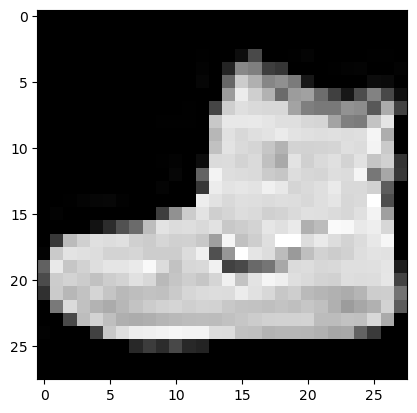

In [12]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))
plt.show()

The first dimension of the input data should contain the batch size (due to `torch.nn` API)

In [13]:
img.shape

torch.Size([1, 28, 28])

In [14]:
pred = model(img[None, :])
print(target, english_labels[target])
print(pred)

9 Ankle boot
tensor([[-2.6250, -2.2063, -1.8975, -2.7263, -2.4924, -1.6666, -2.4997, -2.9292,
         -2.5911, -2.1206]], grad_fn=<LogSoftmaxBackward0>)


We define a train loop

In [15]:
def train(model, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        batch_size = data.shape[0]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(test_loader.dataset)
    return train_loss

And a test function:

In [16]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # sum up batch loss
            _, pred = output.data.max(dim=1)
            # get the index of the max log-probability
            correct += torch.sum(pred == target.data.long()).item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = float(correct) / len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f},'
              ' Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * test_accuracy))
    return test_loss, test_accuracy

The `find_lr` function provides a learning rate for SGD or Adam, following heuristics from https://arxiv.org/abs/1506.01186:

In [17]:
import numpy as np

def loop_loader(data_loader):
    while True:
        for elem in data_loader:
            yield elem

def find_lr(model, train_loader, init_lr, max_lr, steps, n_batch_per_step=30):
    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
    current_lr = init_lr
    best_lr = current_lr
    best_loss = float('inf')
    lr_step = (max_lr - init_lr) / steps

    loader = loop_loader(train_loader)
    for i in range(steps):
        mean_loss = 0
        n_seen_samples = 0
        for j, (data, target) in enumerate(loader):
            if j > n_batch_per_step:
                break
            optimizer.zero_grad()
            if cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            mean_loss += loss.item() * data.shape[0]
            n_seen_samples += data.shape[0]
            optimizer.step()

        mean_loss /= n_seen_samples
        print('Step %i, current LR: %f, loss %f' % (i, current_lr, mean_loss))
            
        if np.isnan(mean_loss) or mean_loss > best_loss * 4:
            return best_lr / 4
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_lr = current_lr

        current_lr += lr_step
        optimizer.param_groups[0]['lr'] = current_lr

    return best_lr / 4

Let's load our model on the GPU if required. We then define an optimizer and a learning rate scheduler

In [18]:
log_interval = 100
epochs = 12

In [19]:
if cuda:
    model.cuda()

model.reset_parameters()
lr = find_lr(model, train_loader, 1e-4, 1, 100, 30)
model.reset_parameters()

print('Best LR', lr)

Step 0, current LR: 0.000100, loss 2.305745
Step 1, current LR: 0.010099, loss 2.204690
Step 2, current LR: 0.020098, loss 1.717935
Step 3, current LR: 0.030097, loss 1.241666
Step 4, current LR: 0.040096, loss 1.051628
Step 5, current LR: 0.050095, loss 1.113315
Step 6, current LR: 0.060094, loss 1.032816
Step 7, current LR: 0.070093, loss 0.993736
Step 8, current LR: 0.080092, loss 0.900236
Step 9, current LR: 0.090091, loss 0.823854
Step 10, current LR: 0.100090, loss 0.791178
Step 11, current LR: 0.110089, loss 0.804942
Step 12, current LR: 0.120088, loss 0.805085
Step 13, current LR: 0.130087, loss 0.767188
Step 14, current LR: 0.140086, loss 0.775382
Step 15, current LR: 0.150085, loss 0.722176
Step 16, current LR: 0.160084, loss 0.750336
Step 17, current LR: 0.170083, loss 0.723112
Step 18, current LR: 0.180082, loss 0.716810
Step 19, current LR: 0.190081, loss 0.730336
Step 20, current LR: 0.200080, loss 0.714219
Step 21, current LR: 0.210079, loss 0.710831
Step 22, current LR:

Let's train our model:

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=3,
                                                       last_epoch=-1)

logs = {'epoch': [], 'train_loss': [], 'test_loss': [],
        'test_accuracy': [], 'lr': []}

In [21]:
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_loader, epoch)
    test_loss, test_accuracy = test(model, test_loader)
    logs['epoch'].append(epoch)
    logs['train_loss'].append(train_loss)
    logs['test_loss'].append(test_loss)
    logs['test_accuracy'].append(test_accuracy)
    logs['lr'].append(optimizer.param_groups[0]['lr'])
    scheduler.step(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317842
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.956910
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.661878
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.860765
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.630526
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.645251
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.527925
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.570341
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.273928
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.730778
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.666461
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.204510
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.353345
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.387856
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.607189
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.497567
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.583817
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.681633
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.492811


/Users/ryanboustany/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4251, Accuracy: 8356/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.440497


/Users/ryanboustany/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.413194
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.365793
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.750515
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.437627
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.616513
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.401706
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.410583
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.521416
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.546623
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.454001
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.506236
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.406716
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.484448
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.488975
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.381195
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.342087
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.275681
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.473836

Test set: Average loss: 0.3419, Accuracy: 8756/10000 (88%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.34753